# Movie Recommendation System

Develop a content-based recommendation system that suggests movies similar to a user's favorite, based on movie attributes like genres, keywords, cast, crew, and overview. This approach doesn't rely on user ratings but focuses on the content of the movies themselves.

We'll break the system into three key parts:

- Representation Learning – Using PCA or Embeddings to reduce high-dimensional features.

- Retrieval Model – A deep learning model that retrieves a list of candidate movies based on similarity.

- Ranking Model – A secondary model that re-ranks the retrieved movies for personalization and relevance.

## Dataset

We'll use the TMDB 5000 Movie Dataset from Kaggle:
https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

## Main files:

- tmdb_5000_movies.csv — Movie metadata.

- tmdb_5000_credits.csv — Cast and crew details.

## Features to Use

- Genres: Movie genres (e.g., Action, Comedy).

- Keywords: Tags associated with the movie.

- Cast: Top 3 cast members.

- Crew: Director of the movie.

- Overview: Brief description of the movie.

## Implementation Steps

- Data Loading and Preprocessing: Load datasets and merge them.

- Feature Extraction: Extract relevant features and combine them.

- Text Vectorization: Convert text data into numerical vectors using TF-IDF.

- Dimensionality Reduction: Apply PCA to reduce feature dimensions.

- Similarity Computation: Compute cosine similarity between movies.

- Recommendation Function: Recommend movies based on similarity scores.

## Imports

- Standard tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (sklearn).

- WordCloud is used for tag visualization.

In [34]:
# Import libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

## Load and Merge datasets

- Load and merge movie metadata and credits datasets on the title.

In [35]:
# Load datasets
movies = pd.read_csv(r'D:\ML\Projects\Recommender-Systems\tmdb_5000_movies.csv')
credits = pd.read_csv(r'D:\ML\Projects\Recommender-Systems\tmdb_5000_credits.csv')

# Merge datasets on 'title'
movies = movies.merge(credits, on='title')

## Select and Clean Features

- Keep only useful columns for content-based recommendations.

- Drop missing values to avoid errors.

In [36]:
# Select relevant features
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.dropna(inplace=True)  # Drop rows with missing values

## Feature Engineering: Extract Names

- Genres, keywords, cast, and crew columns contain stringified JSON.

- These functions extract top actors, genres, keywords, and the director from the crew.

- Apply those extract functions and also normalize text (lowercase, remove spaces) for consistency.

In [37]:
# Define helper functions
def extract_names(obj):
    return [i['name'] for i in ast.literal_eval(obj)]

def extract_top_cast(obj):
    return [i['name'] for i in ast.literal_eval(obj)[:3]]

def extract_director(obj):
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            return i['name']
    return ''

def collapse(lst):
    return [i.replace(" ", "").lower() for i in lst]

## Generate Combined Tags

- Combine overview + genres + keywords + cast + director into a single string called "tags" for each movie.

- This acts as a comprehensive movie "description" for similarity comparison.

In [38]:
# Apply feature engineering
movies['genres'] = movies['genres'].apply(extract_names).apply(collapse)
movies['keywords'] = movies['keywords'].apply(extract_names).apply(collapse)
movies['cast'] = movies['cast'].apply(extract_top_cast).apply(collapse)
movies['crew'] = movies['crew'].apply(extract_director).apply(lambda x: x.replace(" ", "").lower())

In [39]:
# Combine all features into a 'tags' column
movies['tags'] = movies['overview'].apply(lambda x: x.lower()) + ' ' + \
                 movies['genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['keywords'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['cast'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['crew']

## TF-IDF Vectorization

- Converts text into numerical form using TF-IDF (Term Frequency-Inverse Document Frequency).

- Reduces importance of common words and gives more weight to unique terms.

In [40]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
vectors = tfidf.fit_transform(movies['tags']).toarray()

## Dimensionality Reduction using PCA

- Uses Principal Component Analysis (PCA) to reduce TF-IDF vectors into 2D space for visualization.

- Makes it easier to plot and interpret.

- Stores PCA values in the DataFrame for plotting.

In [41]:
# Apply PCA
pca = PCA(n_components=2)  # for visualization, we use 2 components
vectors_pca = pca.fit_transform(vectors)

# Cosine Similarity
similarity = cosine_similarity(vectors)

# Add PCA components to DataFrame for visualization
movies['pca1'] = vectors_pca[:, 0]
movies['pca2'] = vectors_pca[:, 1]

## PCA Visualization

- Visualizes movies in 2D space using pca1 and pca2.

- Colors are based on the first genre, giving a sense of genre clusters.

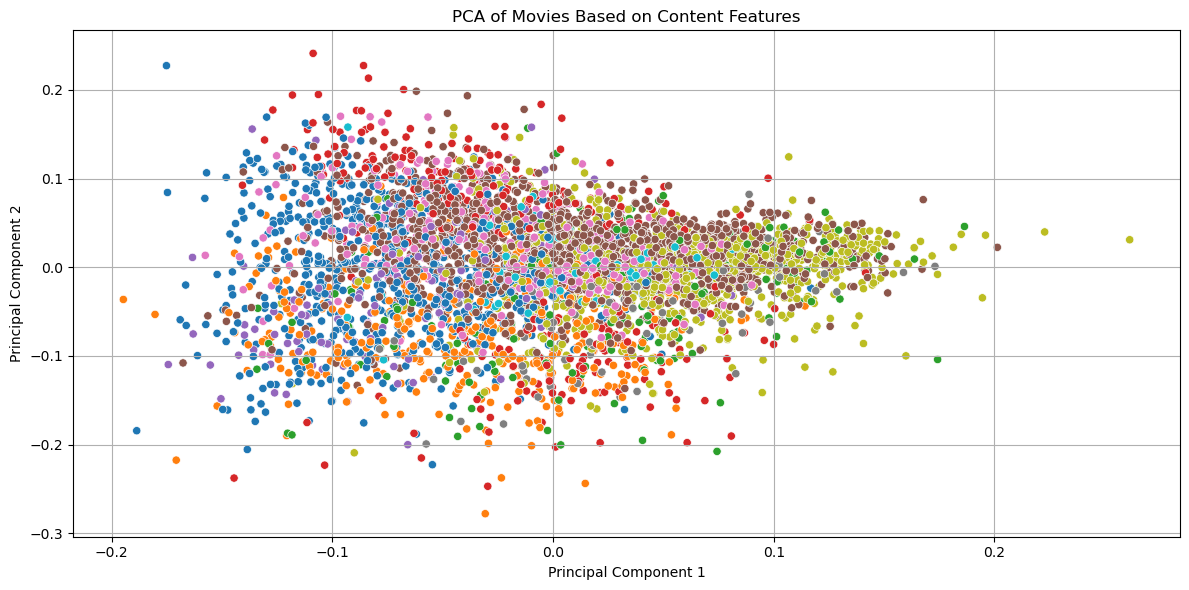

In [42]:
# Visualize PCA result with top genres
plt.figure(figsize=(12, 6))
sns.scatterplot(data=movies, x='pca1', y='pca2', hue=movies['genres'].apply(lambda x: x[0] if x else 'unknown'), palette='tab10', legend=False)
plt.title('PCA of Movies Based on Content Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Word Cloud Visualization

- Builds a word cloud of the most frequent words in movie tags (shows dominant terms like actors, genres, keywords visually).

In [43]:
# Display a word cloud of the tags
all_tags = ' '.join(movies['tags'].values)
wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(all_tags)

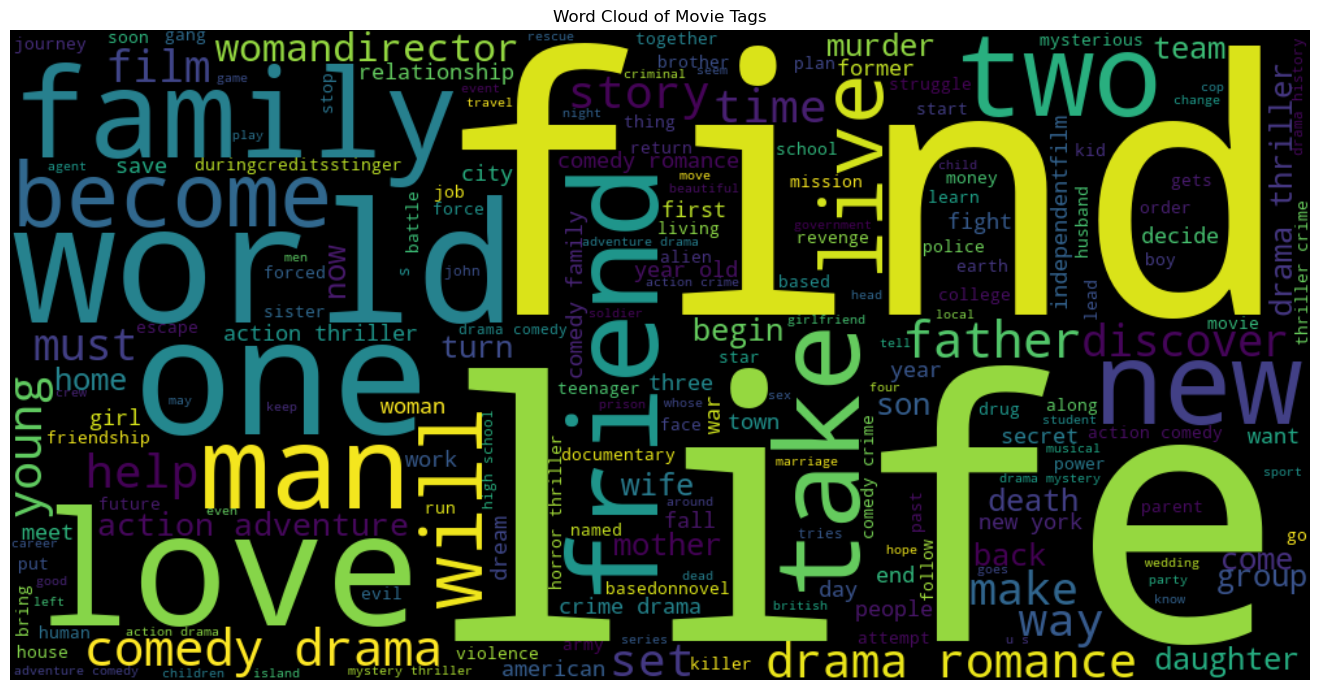

In [44]:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.tight_layout()
plt.show()

## Movie Recommendation Logic

- Finds the index of the selected movie.

- Calculates cosine similarity between that movie and all others using the TF-IDF matrix.

- Sorts and returns top 5 most similar movies (excluding itself).

In [49]:
# Function to recommend movies
def recommend(movie):
    index = movies[movies['title'] == movie].index[0]
    distances = similarity[index]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    recommended_titles = [movies.iloc[i[0]].title for i in movie_list]
    
    print(f"\nTop 5 Recommendations for '{movie}':")
    for title in recommended_titles:
        print(f" - {title}")
    return recommended_titles

In [56]:
# Run recommendation function
recommended = recommend('The Dark Knight')


Top 5 Recommendations for 'The Dark Knight':
 - The Dark Knight Rises
 - Batman Returns
 - Batman Begins
 - Batman Forever
 - Batman: The Dark Knight Returns, Part 2
